# Calculating the column density

## Introduction

I give here an introduction into how you can model a line in order to extract certain parameters such as column density and microturbulence. 

### Please note

The notebook will not work until you have made edits to
the ```params.json``` file. The split_files parameter needs to be set to "no". This workbook only works with part B being selected in ```params.json```. Finally, please run the notebook 'load_the_data' to create a new DP array which can then be loaded in this notebook.

### Load the data

For this worksheet to work you have to set the part to 'B' in the parmams.json file.

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the other part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

Repository home directory: /home/pas/science/exocomets


In [2]:
# Let us now load our entire dataset
DP   = c.LoadData(home+'/data/Dnsn_'+part+'.npz')

### Create a master spectrum
We do a weighted average of the spectra.

In [3]:
import numpy as np

spec        = []
spec_err    = []

for i in range(len(DP)):          # Cycle over number of visits
    for j in range(len(DP[i])):   # Cycle over number of fits files taken during each visit
        spec.append(DP[i][j][1])
        spec_err.append(DP[i][j][2])

spec        = np.array(spec)
spec_err    = np.array(spec_err)

print("Combining",str(len(spec))," spectra")

spec        = c.ReplaceWithSmallNumber(spec)
spec_err    = c.ReplaceWithOne(spec_err)

weights     = 1./(spec_err**2)
weights     = weights/np.sum(weights)   # Technically not needed as np.average does this

spec_w_ave  = np.average(spec, axis=0, weights=weights)
errorbars_2 = np.sum((weights*spec_err)**2, axis=0)

Combining 35  spectra


In [4]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 18,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 16,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

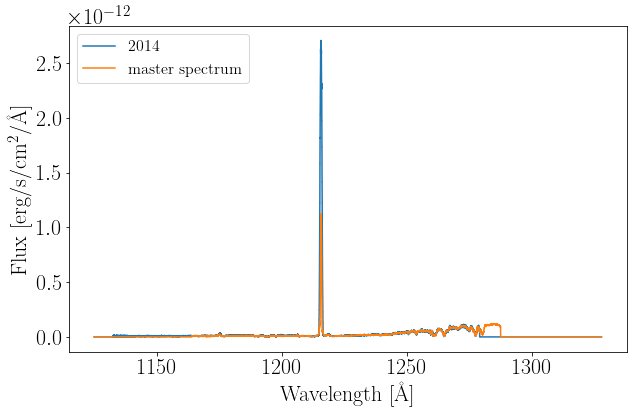

In [5]:
#%matplotlib widget
fig = plt.figure(figsize=(10.0,6.0))
w= DP[0][0][0]
plt.step(w,DP[0][0][1],label="2014")
plt.step(w,spec_w_ave,label="master spectrum")
plt.legend(loc='upper left', numpoints=1)
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

We see that the master spectrum is a lot less noisy compared to the spectrum taken in 2014 as an example.

### Selecting a line

We next select a region centered on the SII line at 1250.5840 Å. To speed up calculations we only deal with the region of interest, cutting away the rest of the data.

Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

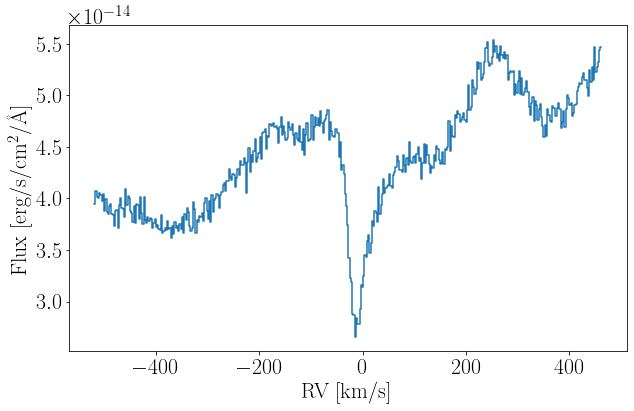

In [6]:
s1, s2 = c.RegionSelect(w, 1248.5, 1252.6)

W = w[s1:s2]
S = spec_w_ave[s1:s2]

# This function converts from wavelength to RV values and puts it in the $\beta$ Pic reference frame.
RV = c.Wave2RV(W,param["lines"]["line"]['SII']["Wavelength"],param["BetaPictoris"]["RV"])

fig = plt.figure(figsize=(10.0,6.0))
plt.step(RV,S)
plt.xlabel(r'RV [km/s]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

### Selecting a line

We now want to model an absorption component. In this case we want to model SII where the line is formed by absorbing gas in the debris disk. This function exits in `src/calculations.py` but is included here for your convenience.

In [7]:
def absorption(l, v_comp, N, vturb, T, species):
    # v_comp --> The component speed in km/s
    # N --> The column density exponent (10**N)
    # vturb --> Micro turbulence
    # T --> Gas temperature
    # species --> Given in params.json

    w       = param["lines"]["line"][species]["Wavelength"]
    mass    = param["lines"]["line"][species]["Mass"]
    fosc    = param["lines"]["line"][species]["Strength"]
    delta   = param["lines"]["line"][species]["Gamma"] /(4.*np.pi)
    N_col   = np.array([1.])*10**N

    c_light     = 2.99793e14        # Speed of light
    k           = 1.38064852e-23    # Boltzmann constant in J/K = m^2*kg/(s^2*K) in SI base units
    u           = 1.660539040e-27   # Atomic mass unit (Dalton) in kg
    feature  = np.ones(len(l))

    b_wid   = np.sqrt((T/mass) + ((vturb/0.12895223)**2))
    b       = 4.30136955e-3*b_wid
    dnud    = b*c_light/w
    xc      = l/(1.+v_comp*1.e9/c_light) 
    v       = 1.e4*abs(((c_light/xc)-(c_light/w))/dnud)
    tv      = 1.16117705e-14*N_col*w*fosc/b_wid
    a       = delta/dnud
    hav     = tv*m.voigt_wofz(a,v)

    # To avoid calculating super tiny numbers
    for j in range(len(hav)):

        if hav[j] < 50:      
            feature[j]  =   feature[j]*np.exp(-hav[j])       
        else:
            feature[j]  =   0.

    return feature

### Modelling a continuum

Here we model a continuum using a third order polynomial. We make sure we exclude the spectral feature we want to fit.

In [8]:
p1, p2 = c.RegionSelect(W, 1250, 1250.5)
p3, p4 = c.RegionSelect(W, 1250.8, 1251.5)
x_fit_region = np.concatenate((W[p1:p2],W[p3:p4]))
y_fit_region = np.concatenate((S[p1:p2],S[p3:p4]))
polynomial_coeff= np.polyfit(x_fit_region,y_fit_region,3)
continuum=np.polyval(polynomial_coeff,W)

We create a model of the absorption. 20.5 km/s (system speed of beta pic)

In [9]:
abs_model = absorption(W,0.5, 16, 2.5, 10, 'SII')
model = abs_model*continuum

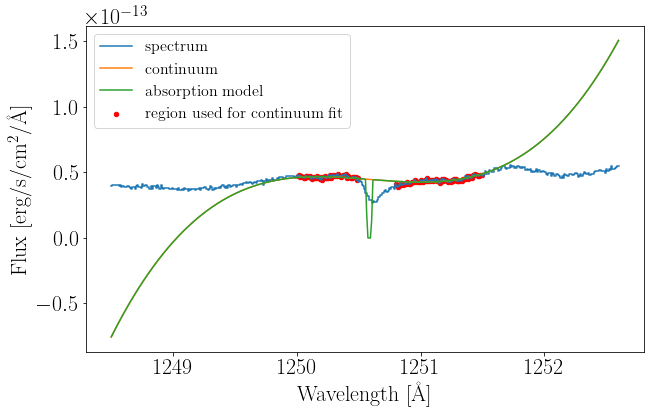

In [10]:
#%matplotlib widget
fig = plt.figure(figsize=(10.0,6.0))
plt.step(W,S,label="spectrum")
plt.plot(W,continuum,label="continuum")
plt.plot(W,model,label="absorption model")
plt.scatter(x_fit_region,y_fit_region,c="red",s=20,label="region used for continuum fit")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.legend(loc='upper left', numpoints=1)

### Computing a line spread function (LSF)

This might look like a very poor fit, but keep this in mind: No instrument is perfect and so the insturment itself does broaden the line. The amound of broadening is wavelength dependent. The COS team have computed the line spread function (LSF) for a number of wavenlenghts. Please [read this](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution). In our case they are:

In [11]:
X               =  np.genfromtxt(home+'/src/aa_LSFTable_G130M_1291_LP3_cn.dat', unpack=True).T[0]
print(X)

[1134. 1139. 1144. 1149. 1154. 1159. 1164. 1169. 1174. 1179. 1184. 1189.
 1194. 1199. 1204. 1209. 1214. 1219. 1224. 1229. 1234. 1239. 1244. 1249.
 1254. 1259. 1264. 1269. 1274. 1295. 1300. 1305. 1310. 1315. 1320. 1325.
 1330. 1335. 1340. 1345. 1350. 1355. 1360. 1365. 1370. 1375. 1380. 1385.
 1390. 1395. 1400. 1405. 1410. 1415. 1420. 1425. 1430.]


In [12]:
# Our line is at 1250.5840
SII_w = param["lines"]["line"]["SII"]["Wavelength"]
print(SII_w)

1250.584


In [13]:
# The closest LSF for us is:
closest_LSF     = min(X, key=lambda x:abs(x-SII_w))
print(closest_LSF)

1249.0


Let us now look at what it looks like

Text(0.5, 0, 'Pixels')

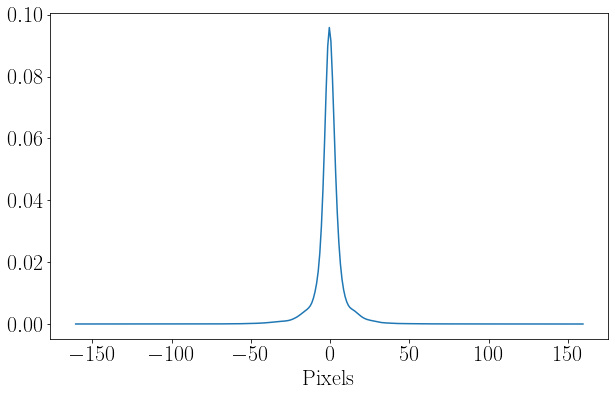

In [14]:
import pandas as pd

df              = pd.read_csv(home+'/src/aa_LSFTable_G130M_1291_LP3_cn.dat', delim_whitespace=True)
y_LSF_tabu      = df[0:][str(int(closest_LSF))]

# We re-center the LSF on 0
x_LSF_tabu    = np.arange(-len(y_LSF_tabu)/2,len(y_LSF_tabu)/2)

# If you were looking at an extremely thin line at x=0 the instrument would at best
# only be able to resolve the following
fig = plt.figure(figsize=(10.0,6.0))
plt.plot(x_LSF_tabu,y_LSF_tabu)
plt.xlabel(r'Pixels')

Text(0.5, 0, 'COS Pixels')

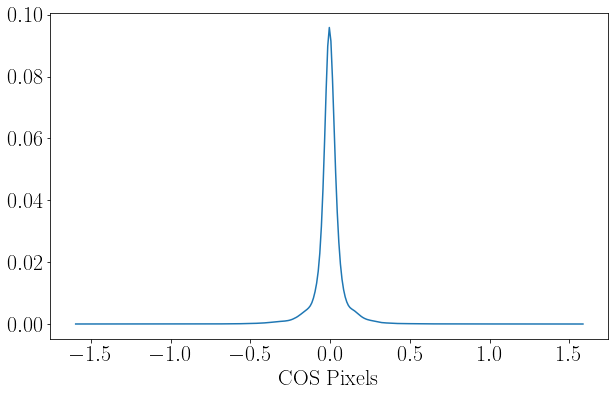

In [15]:
# We calculate how many Ångstrom a COS wavelength step is
dw_cos          = (W[-1]-W[0])/len(W)

# We wish to calculate the linespread function over our wavelength range,
# which we shift so that the line is centered
x_LSF_kernel_cos  = W-SII_w

# We convert the tabulated values to the COS wavelenght scale
x_LSF_tabu_cos  = x_LSF_tabu*dw_cos
y_LSF_tabu_cos  = y_LSF_tabu*dw_cos

# Note that the input spectrum must be broader than the LSF kernel (321 pixels)
# So in other words len(x_LSF_kernel_cos) > len(x_LSF_tabu_cos) must be true
# If it is not the case, you must select a broader wavelength range.
LSF_kernel      = np.interp(x_LSF_kernel_cos, x_LSF_tabu_cos, y_LSF_tabu)

#We normalise the LSF kernel
LSF_kernel      = LSF_kernel/np.sum(LSF_kernel)

fig = plt.figure(figsize=(10.0,6.0))
plt.plot(x_LSF_tabu_cos, y_LSF_tabu)
plt.xlabel(r'COS Pixels')

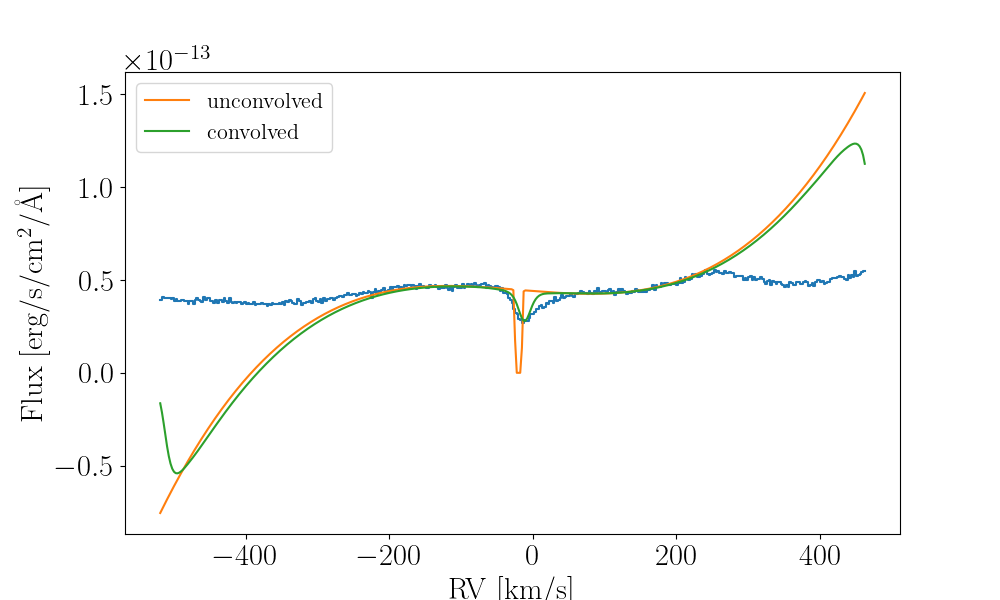

In [16]:
%matplotlib widget
# We now convolve our absortion model with the LSF kernel
model_convolved = np.convolve(model, LSF_kernel, mode='same')

#RV = c.Wave2RV(W,param["lines"]["line"]['SII']["Wavelength"],20.5)

fig = plt.figure(figsize=(10.0,6.0))
plt.step(RV,S)
plt.plot(RV,model,label="unconvolved")
plt.plot(RV,model_convolved,label="convolved")

plt.xlabel(r'RV [km/s]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.legend(loc='upper left', numpoints=1)

### Varying column density

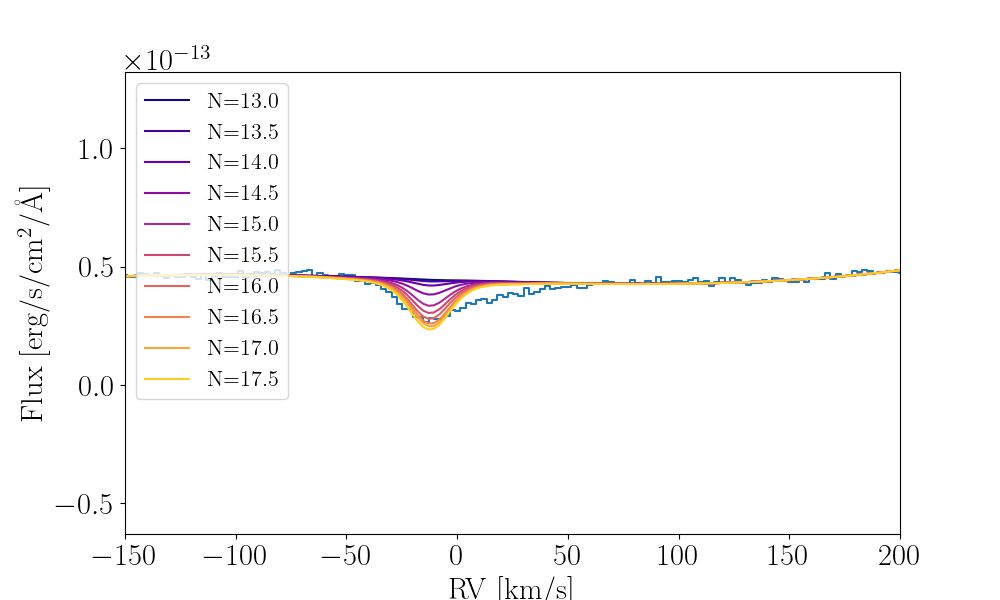

In [17]:
fig = plt.figure(figsize=(10.0,6.0))
plt.step(RV,S)

col_dens=np.arange(13,18,0.5)

cool=cm.plasma(np.linspace(0.0,0.9,len(col_dens))) # Create some nice colours for the plot

for i in range(len(col_dens)):
    abs_model = m.absorption(W,0, col_dens[i], 2.5, 10, param["lines"]["chosen_line"],param)
    model = abs_model*continuum
    model_convolved = np.convolve(model, LSF_kernel, mode='same')
    plt.plot(RV,model_convolved,color=cool[i],label="N="+str(col_dens[i]))

plt.xlim(-150,200)
plt.xlabel(r'RV [km/s]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.legend(loc='upper left', numpoints=1)

### Varying the microturbulence

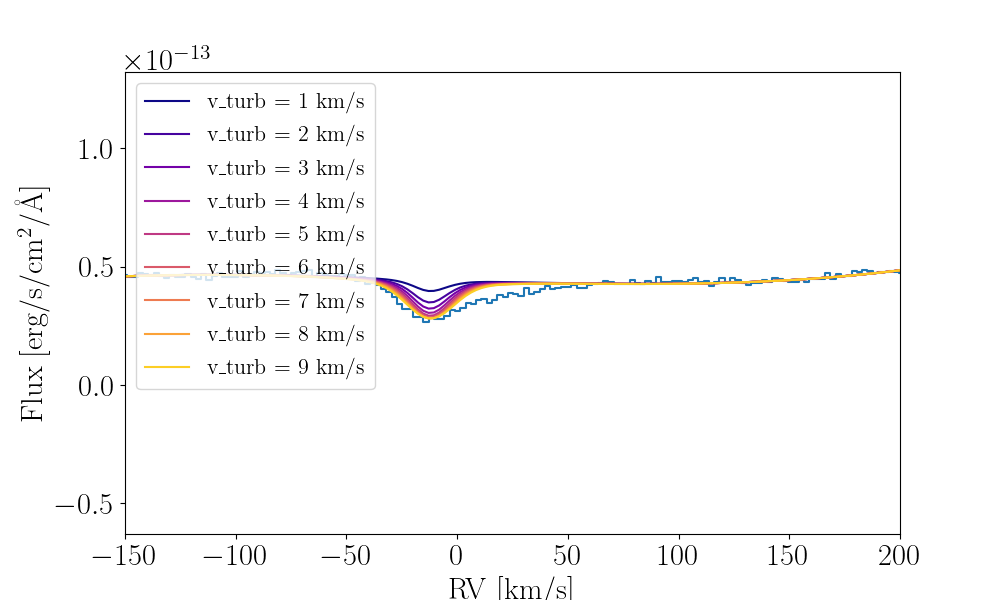

In [18]:
fig = plt.figure(figsize=(10.0,6.0))
plt.step(RV,S)

v_turb=np.arange(1,10)

cool=cm.plasma(np.linspace(0.0,0.9,len(v_turb))) # Create some nice colours for the plot

for i in range(len(v_turb)):
    abs_model = m.absorption(W,0, 15, v_turb[i], 10, param["lines"]["chosen_line"],param)
    model = abs_model*continuum
    model_convolved = np.convolve(model, LSF_kernel, mode='same')
    plt.plot(RV,model_convolved,color=cool[i],label="v_turb = "+str(v_turb[i])+" km/s")

plt.xlim(-150,200)
plt.xlabel(r'RV [km/s]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.legend(loc='upper left', numpoints=1)